# IndAIna - Classifying origin of ceramic artifacts

In [81]:
from fastai.vision import *
import shutil
import os
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [10, 10]

In [3]:
from zipfile import ZipFile
with ZipFile('data/images-20191220T222209Z-001.zip', 'r') as archive:
    archive.extractall('data/')

## Use datablock to convert data

### Search and scroll

### Create directory and upload urls file into your server

Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

You will need to run this cell once per each category.

In [10]:
#Define function to grab classes from the file name itself

path = Path('./data/Belongs In a Museum')
folder = 'Belongs In a Museum'

#Get the class name
def get_class_from_name(path):
    return [str(x).split("_")[0].split("/")[-1] for x in path.ls()]

class_series = pd.DataFrame(get_class_from_name(path), columns = ['classes'])

#Count the number of artifacts in each Country
count_artifact = class_series.groupby(['classes']).size().reset_index().sort_values([0], ascending = False)
count_artifact.columns = ['classes','count']

count_artifact

classes  count
11                                     Egypt   1055
22                                      Peru    824
18                                    Mexico    465
3                            Byzantine Egypt    380
9                                    Ecuador     79
26                             United States     55
6                                 Costa Rica     35
27                                       nan     29
14                                 Guatemala     15
5                        Colombia or Ecuador     14
17                                      Iran     11
21                                    Panama     11
4                                   Colombia     11
15                       Guatemala or Mexico     10
8                         Dominican Republic      8
12                           Egypt and Sudan      2
20                                 Nicaragua      2
24                                     Syria      1
23  Republic of the Congo or Cabinda, Angola      1
25                                    Turkey      1
0                                     Angola      1
19                       Mexico or Guatemala      1
16                                 Indonesia      1
1                            Bolivia or Peru      1
13                  El Salvador or Guatemala      1
10                           Ecuador or Peru      1
7                                     Cyprus      1
2                                     Brazil      1
28                     probably Western Iran      1

In [20]:
#Remove countries with less than 8 and with no country designation
remove_image_list = count_artifact.loc[(count_artifact['count'] < 8) | (count_artifact.classes == 'nan')].classes.values
remove_image_list

array(['nan', 'Egypt and Sudan', 'Nicaragua', 'Syria', 'Republic of the Congo or Cabinda, Angola', 'Turkey', 'Angola',
       'Mexico or Guatemala', 'Indonesia', 'Bolivia or Peru', 'El Salvador or Guatemala', 'Ecuador or Peru', 'Cyprus',
       'Brazil', 'probably Western Iran'], dtype=object)

In [26]:
#Suggest removing files that have less than 8 and nan
#Folders must exist prior
path = './/data//Belongs In a Museum'
dest = './/data//Treasures'

files = os.listdir(path)

#Remove images that are in the remove list
for f in files:
    if (f.startswith(tuple(remove_image_list))):
        shutil.move(path + '//' + f, dest)

In [3]:
#Create a data bunch from the datablock api framework
func= lambda x: (str(x).split("_")[0].split("/")[-1])

path = Path('./data/Belongs In a Museum')
tfms = get_transforms(do_flip=False)
data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()            #Split by random percentage, defaults to 20%
        .label_from_func(func)          #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=224)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

## View data

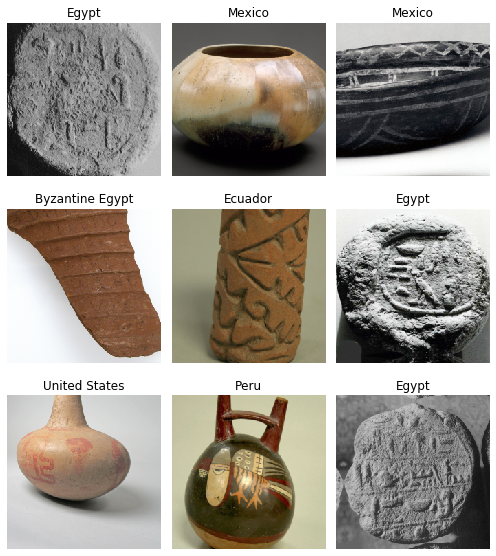

In [5]:
#View random selection of images 
data.show_batch(rows=3, figsize=(7,8))

In [6]:
#Look at the classes, number of classes, # of images in training and test set
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Byzantine Egypt',
  'Colombia',
  'Colombia or Ecuador',
  'Costa Rica',
  'Dominican Republic',
  'Ecuador',
  'Egypt',
  'Guatemala',
  'Guatemala or Mexico',
  'Iran',
  'Mexico',
  'Panama',
  'Peru',
  'United States'],
 14,
 2379,
 594)

## Train model

In [4]:
#Set up the cnn and train with the data block and test set
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [39]:
#Use the one-cycle method to train model
learn.fit_one_cycle(4)

In [40]:
#Save the weights
learn.save('stage-1')

In [41]:
#Unfreeze the entire network
learn.unfreeze()

In [42]:
#Run learning rate finder
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


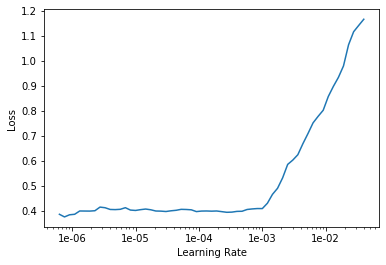

In [43]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [46]:
#Rule of thumb is to take the default end learning rate and divide by 5 or 10
#Since the lower learning rate remains horizontal, I took a larger learning rate. 
learn.fit_one_cycle(4, max_lr=slice(1e-4,0.003/5))

In [47]:
#Saving weights from second model
learn.save('stage-2')

## Interpretation

In [5]:
#Load the second model's weights
learn.load('stage-2');

In [6]:
#Create a interpretation object
interp = ClassificationInterpretation.from_learner(learn)

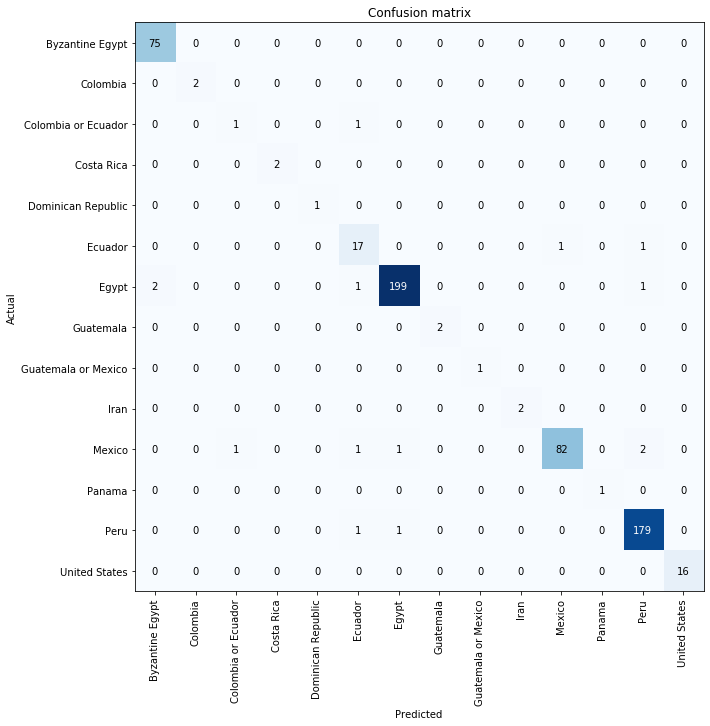

In [7]:
#Create confusion matrix
interp.plot_confusion_matrix()

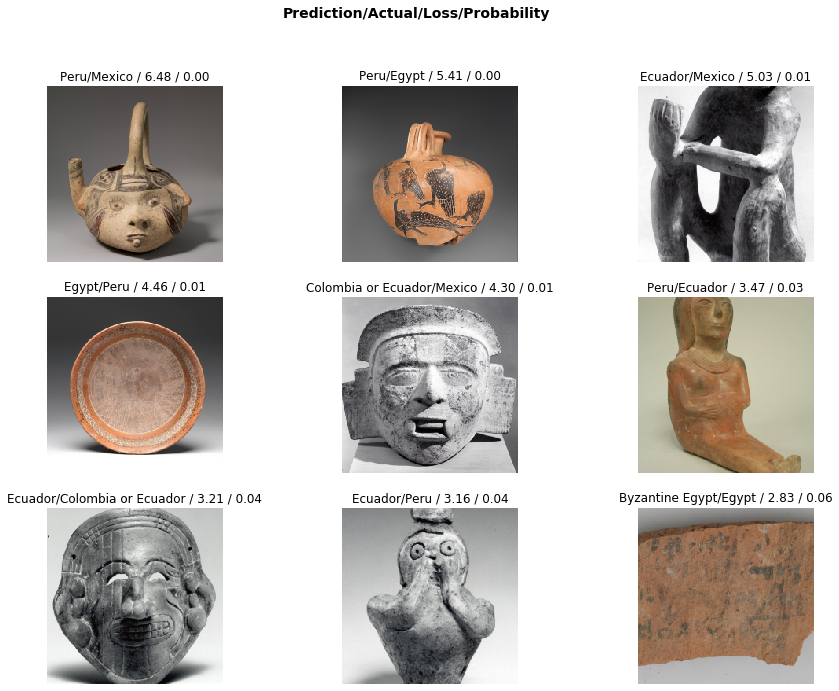

In [8]:
#Plot greatest losses between predictions and actuals
interp.plot_top_losses(9, figsize=(15,11))

In [9]:
#The most confused pairs of artifacts
interp.most_confused(min_val=2)

[('Egypt', 'Byzantine Egypt', 2), ('Mexico', 'Peru', 2)]

# Explore the unknown

In [10]:
#Export the cnn with the second set of weights
learn.export()

In [28]:
defaults.device = torch.device('cpu')

In [29]:
#Load the cnn model from the folder
path = Path('data/Belongs In a Museum')
learn = load_learner(path)

Predicted class : EGYPT / Actual Class : NAN


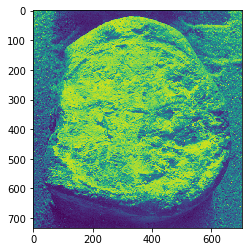

Predicted class : EGYPT / Actual Class : NAN


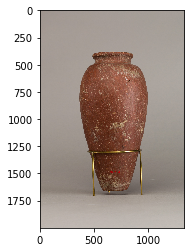

Predicted class : EGYPT / Actual Class : NAN


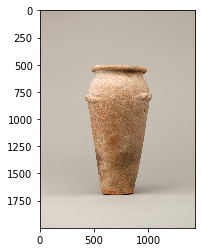

Predicted class : MEXICO / Actual Class : BRAZIL


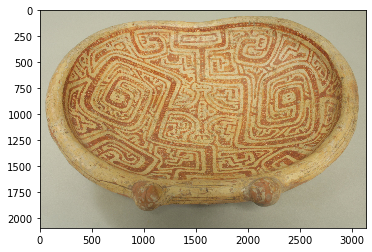

Predicted class : EGYPT / Actual Class : NAN


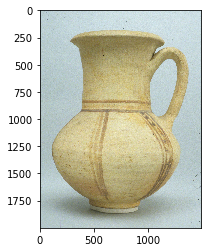

Predicted class : EGYPT / Actual Class : NAN


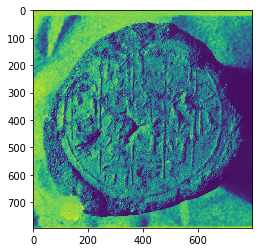

Predicted class : MEXICO / Actual Class : INDONESIA


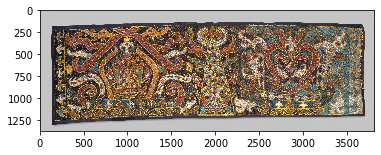

Predicted class : PERU / Actual Class : SYRIA


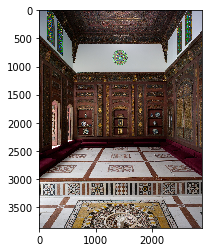

Predicted class : EGYPT / Actual Class : NAN


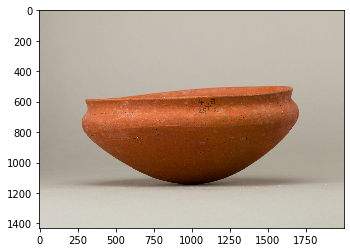

Predicted class : EGYPT / Actual Class : NAN


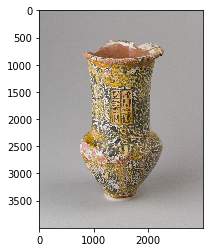

Predicted class : MEXICO / Actual Class : NAN


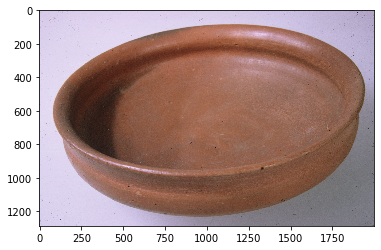

Predicted class : MEXICO / Actual Class : EL SALVADOR OR GUATEMALA


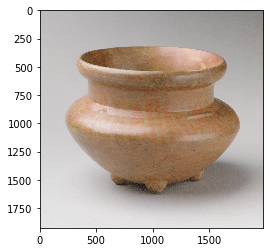

Predicted class : PERU / Actual Class : ECUADOR OR PERU


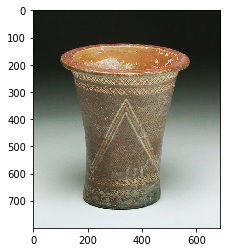

Predicted class : PERU / Actual Class : NICARAGUA


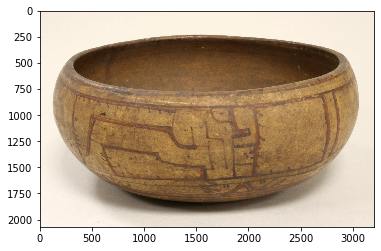

Predicted class : EGYPT / Actual Class : NAN


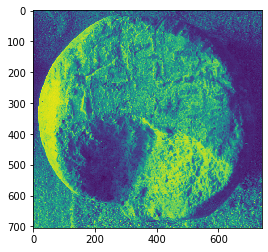

Predicted class : EGYPT / Actual Class : NAN


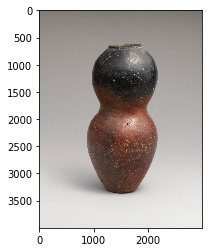

Predicted class : EGYPT / Actual Class : NAN


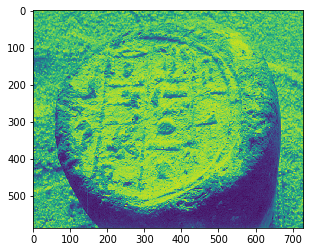

Predicted class : EGYPT / Actual Class : NAN


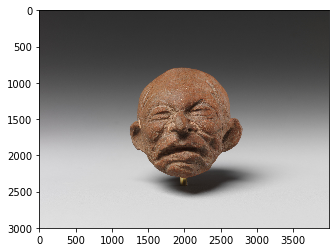

Predicted class : EGYPT / Actual Class : NAN


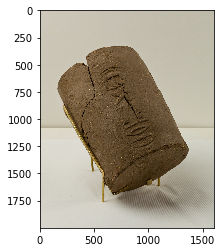

Predicted class : EGYPT / Actual Class : NAN


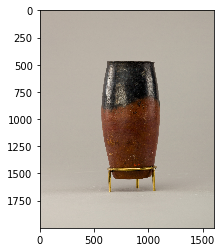

Predicted class : MEXICO / Actual Class : PROBABLY WESTERN IRAN


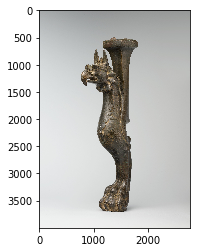

Predicted class : EGYPT / Actual Class : NAN


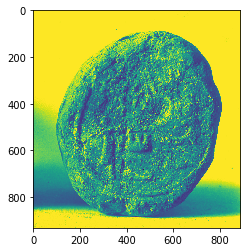

Predicted class : EGYPT / Actual Class : NAN


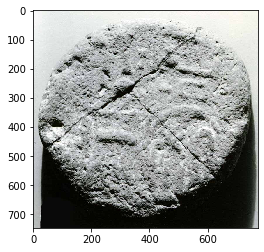

Predicted class : EGYPT / Actual Class : EGYPT AND SUDAN


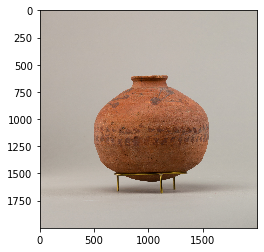

Predicted class : EGYPT / Actual Class : NAN


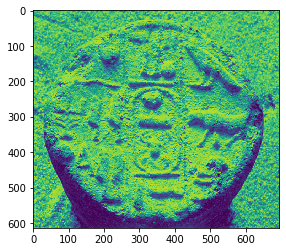

Predicted class : EGYPT / Actual Class : NAN


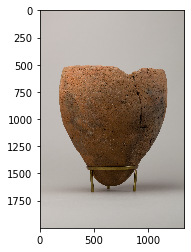

Predicted class : MEXICO / Actual Class : REPUBLIC OF THE CONGO OR CABINDA, ANGOLA


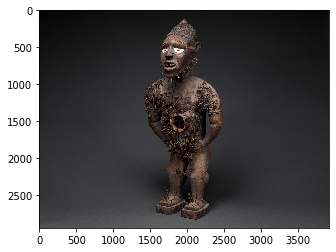

Predicted class : EGYPT / Actual Class : NAN


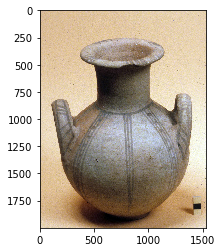

Predicted class : GUATEMALA OR MEXICO / Actual Class : MEXICO OR GUATEMALA


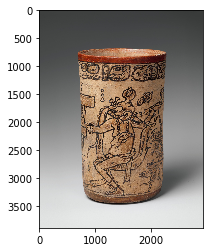

Predicted class : EGYPT / Actual Class : NAN


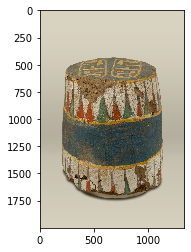

Predicted class : MEXICO / Actual Class : BOLIVIA OR PERU


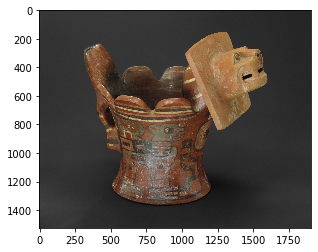

Predicted class : PERU / Actual Class : EGYPT AND SUDAN


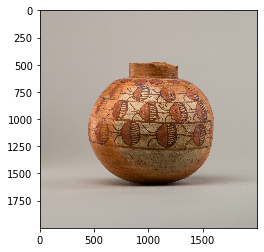

Predicted class : EGYPT / Actual Class : NAN


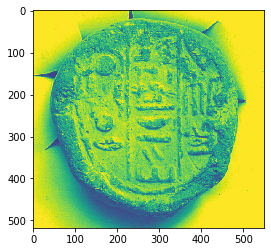

Predicted class : EGYPT / Actual Class : NAN


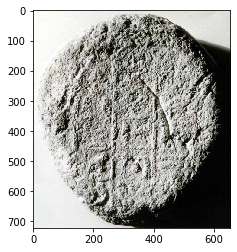

Predicted class : BYZANTINE EGYPT / Actual Class : NAN


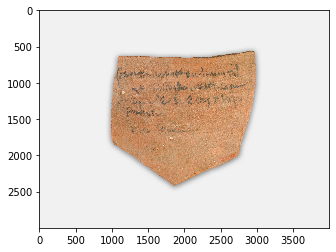

Predicted class : BYZANTINE EGYPT / Actual Class : NAN


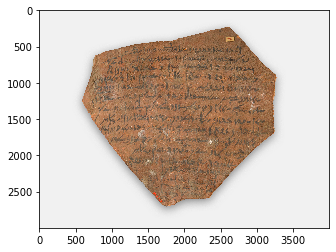

Predicted class : COLOMBIA / Actual Class : CYPRUS


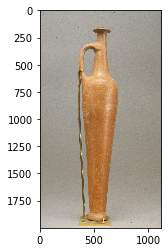

Predicted class : EGYPT / Actual Class : NAN


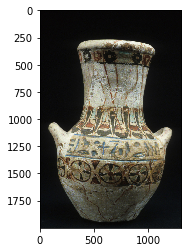

Predicted class : IRAN / Actual Class : TURKEY


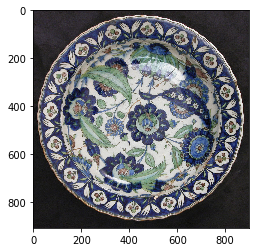

Predicted class : EGYPT / Actual Class : NAN


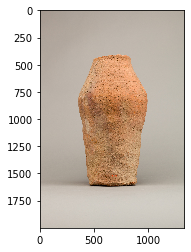

Predicted class : EGYPT / Actual Class : NAN


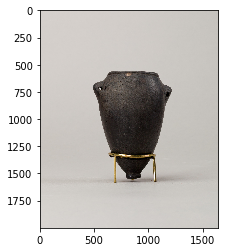

Predicted class : EGYPT / Actual Class : ANGOLA


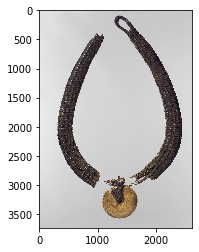

Predicted class : EGYPT / Actual Class : NAN


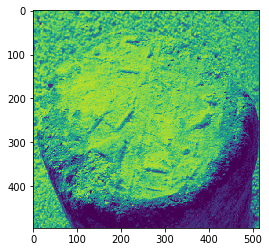

Predicted class : PERU / Actual Class : NAN


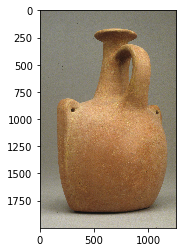

Predicted class : MEXICO / Actual Class : NICARAGUA


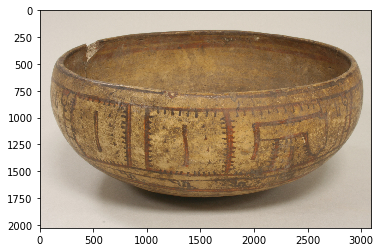

In [43]:
%matplotlib inline

#From the treasure folder which has images below 8 and nan predict their country.
path = Path('data/Treasures')
for i in path.ls():
    plt.figure()
    im = np.array(Image.open(i))
    pred_class,pred_idx,outputs = learn.predict(open_image(i))
    actual_class = (str(i).split("_")[0].split("/")[-1])
    print("Predicted class", ":", str(pred_class).upper(), "/", "Actual Class", ":", str(actual_class).upper())
    plt.imshow(im)
    plt.show()

Predicted class : EGYPT


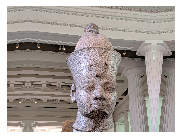

Predicted class : MEXICO


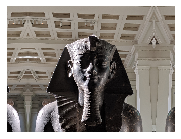

Predicted class : PERU


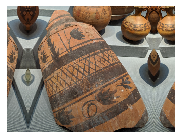

Predicted class : EGYPT


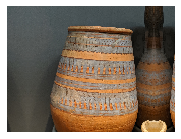

Predicted class : EGYPT


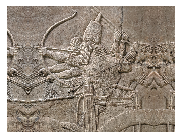

Predicted class : MEXICO


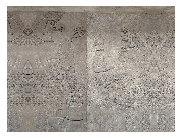

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted class : EGYPT


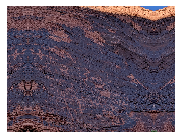

In [112]:
#Have the model guess the predicted class for my own pictures I took
from PIL import Image
%matplotlib inline

path = Path('data/PixelPhotos')
for i in path.ls():
    im = open_image(i).rotate(-90)
    pred_class,pred_idx,outputs = learn.predict(im)
    actual_class = str(i).split("/")[-1].split(".")[0]
    plt.show()
    print("Predicted class", ":", str(pred_class).upper())
    show_image(im)